# Welcome  

Notebook Author: Samuel Alter  
Notebook Subject: Capstone Project - Geographic Analysis

BrainStation Winter 2023: Data Science

## Introduction

This notebook works through an analysis of geographic data (i.e., elevation and aspect) - looking at its influence on wildfire incidence. We want to see if these features of the landscape can accurately predict when a wildfire will be more likely. The location of study for this project are the Santa Monica Mountains, an east-west trending mountain range.

The dataset consists of a high-density grid that has elevation and aspect data appended to each point. Also added to each point is whether there was a wildfire in that location. The elevation and aspect data are sourced from [USGS EarthExplorer](https://earthexplorer.usgs.gov), using the SRTM elevation dataset. The wildfire data is sourced from the [National Interagency Fire Center](https://data-nifc.opendata.arcgis.com/datasets/nifc::interagencyfireperimeterhistory-all-years-view/explore?location=39.778749%2C-121.769073%2C11.96). 

This notebook uses the .csv written in the final step from the Perimeters file. The .csv has already been cleaned and ready for further processing and modeling.

Please refer to the visualization notebook to see maps of the field site.

## Initial Setup

### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

In [2]:
# import geographic information .CSV

df_original=pd.read_csv('/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/shapefiles/joins/layer_combine.csv')
df_original

,elevation,aspect,slope,fire
0,229.0,90.000000,1.891522,0
1,230.0,180.000000,0.535182,0
2,227.0,147.528809,2.269464,0
3,226.0,149.036240,1.559970,0
4,228.0,206.565048,2.037113,0
...,...,...,...,...
19831,92.0,249.702423,19.977131,1
19832,120.0,222.709396,18.289597,1
19833,134.0,228.990921,15.892071,1
19834,149.0,233.686356,25.691380,1


##### Convert aspect, which is a continuous variable, into a categorical.

First, rename columns.

In [3]:
# rename columns
sm_geo=df_original.copy()

In [4]:
sm_geo['asp_cont']=sm_geo['aspect']

sm_geo['elev_cont']=sm_geo['elevation']

sm_geo['slope_cont']=sm_geo['slope']

sm_geo

,elevation,aspect,slope,fire,asp_cont,elev_cont,slope_cont
0,229.0,90.000000,1.891522,0,90.000000,229.0,1.891522
1,230.0,180.000000,0.535182,0,180.000000,230.0,0.535182
2,227.0,147.528809,2.269464,0,147.528809,227.0,2.269464
3,226.0,149.036240,1.559970,0,149.036240,226.0,1.559970
4,228.0,206.565048,2.037113,0,206.565048,228.0,2.037113
...,...,...,...,...,...,...,...
19831,92.0,249.702423,19.977131,1,249.702423,92.0,19.977131
19832,120.0,222.709396,18.289597,1,222.709396,120.0,18.289597
19833,134.0,228.990921,15.892071,1,228.990921,134.0,15.892071
19834,149.0,233.686356,25.691380,1,233.686356,149.0,25.691380


In [5]:
def degToCompass(num):
    '''
    From https://stackoverflow.com/questions/\
    7490660/converting-wind-direction-in-angles-to-text-words
    
    Takes a value between 0 and 360 and 
    outputs the corresponding compass representation
    '''
    val=int((num/22.5)+.5)
    arr=["N","NNE","NE","ENE","E","ESE", "SE", "SSE","S","SSW","SW","WSW","W","WNW","NW","NNW"]
    return arr[(val % 16)]

degToCompass(355)

'N'

In [6]:
sm_geo['asp_cont']

0         90.000000
1        180.000000
2        147.528809
3        149.036240
4        206.565048
            ...    
19831    249.702423
19832    222.709396
19833    228.990921
19834    233.686356
19835    227.563766
Name: asp_cont, Length: 19836, dtype: float64

In [7]:
# `.apply` the function degToCompass
# to each row in the column thusly:
sm_geo['asp_cat']=sm_geo['asp_cont'].apply(degToCompass)
sm_geo

,elevation,aspect,slope,fire,asp_cont,elev_cont,slope_cont,asp_cat
0,229.0,90.000000,1.891522,0,90.000000,229.0,1.891522,E
1,230.0,180.000000,0.535182,0,180.000000,230.0,0.535182,S
2,227.0,147.528809,2.269464,0,147.528809,227.0,2.269464,SSE
3,226.0,149.036240,1.559970,0,149.036240,226.0,1.559970,SSE
4,228.0,206.565048,2.037113,0,206.565048,228.0,2.037113,SSW
...,...,...,...,...,...,...,...,...
19831,92.0,249.702423,19.977131,1,249.702423,92.0,19.977131,WSW
19832,120.0,222.709396,18.289597,1,222.709396,120.0,18.289597,SW
19833,134.0,228.990921,15.892071,1,228.990921,134.0,15.892071,SW
19834,149.0,233.686356,25.691380,1,233.686356,149.0,25.691380,SW


In [8]:
sm_geo['asp_cat'].value_counts()

SSE    1722
S      1672
SSW    1463
N      1427
NNE    1394
SE     1319
NNW    1268
NE     1213
SW     1200
ESE    1157
NW     1121
ENE    1068
WSW    1030
E      1001
WNW     894
W       887
Name: asp_cat, dtype: int64

##### Convert elevation, which is a continuous variable, into a categorical.

First, rename columns.

In [9]:
# rename columns

sm_geo['elev_cont']=sm_geo['elevation']
sm_geo=sm_geo.rename({'elevation':'elev_cat'},axis=1)

sm_geo['slope_cont']=sm_geo['slope']
sm_geo=sm_geo.rename({'slope':'slope_cat'},axis=1)

sm_geo=sm_geo[['asp_cont','asp_cat','elev_cont','elev_cat','slope_cont','slope_cat','fire']]
sm_geo.head(1)

,asp_cont,asp_cat,elev_cont,elev_cat,slope_cont,slope_cat,fire
0,90.0,E,229.0,229.0,1.891522,1.891522,0


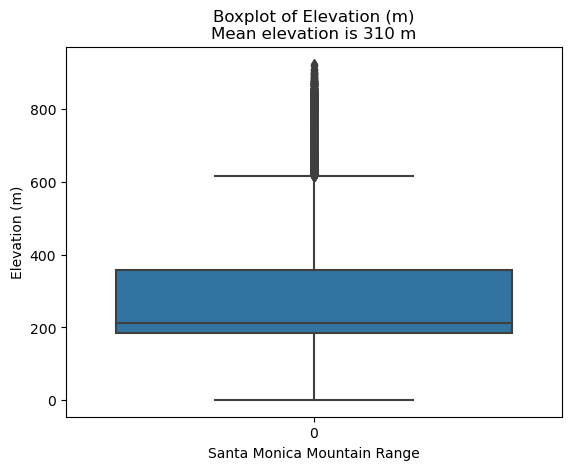

count    19836.000000
mean       281.611867
std        203.469005
min          1.000000
25%        185.000000
50%        212.000000
75%        357.000000
max        924.000000
Name: elev_cont, dtype: float64

In [10]:
chart=sns.boxplot(data=sm_geo['elev_cont'])
chart.set_title('Boxplot of Elevation (m)\nMean elevation is 310 m')
chart.set_ylabel('Elevation (m)')
chart.set_xlabel('Santa Monica Mountain Range')
plt.show()

sm_geo['elev_cont'].describe()

In [11]:
sm_geo.shape

(19836, 7)

I will categorize the elevation into four quartiles:
* $0-25\%$
* $25-50\%$
* $50-75\%$
* $>75\%$

In [12]:
def elevCategorizer(df_col):
    '''
    Hard-codes elevation bins into:
    
    low, medium, high, very high
    1-185, 185-212, 212-357, 357-924
    '''
    
    if df_col <= 185:
        return 'elev_low'
    elif df_col <= 212:
        return 'elev_med'
    elif df_col <= 357:
        return 'elev_high'
    else:
        return 'elev_vhigh'
        
elevCategorizer(450)

'elev_vhigh'

In [13]:
# `.apply` the function elevCategorizer
# to each row in the column thusly:
sm_geo['elev_cat']=sm_geo['elev_cont'].apply(elevCategorizer)
sm_geo

,asp_cont,asp_cat,elev_cont,elev_cat,slope_cont,slope_cat,fire
0,90.000000,E,229.0,elev_high,1.891522,1.891522,0
1,180.000000,S,230.0,elev_high,0.535182,0.535182,0
2,147.528809,SSE,227.0,elev_high,2.269464,2.269464,0
3,149.036240,SSE,226.0,elev_high,1.559970,1.559970,0
4,206.565048,SSW,228.0,elev_high,2.037113,2.037113,0
...,...,...,...,...,...,...,...
19831,249.702423,WSW,92.0,elev_low,19.977131,19.977131,1
19832,222.709396,SW,120.0,elev_low,18.289597,18.289597,1
19833,228.990921,SW,134.0,elev_low,15.892071,15.892071,1
19834,233.686356,SW,149.0,elev_low,25.691380,25.691380,1


In [14]:
sm_geo['elev_cat'].value_counts()

elev_low      5051
elev_high     4960
elev_vhigh    4952
elev_med      4873
Name: elev_cat, dtype: int64

The spread in elevation as binned by quartiles is very even.

##### Convert slope, which is a continuous variable, into a categorical.

First, rename columns.

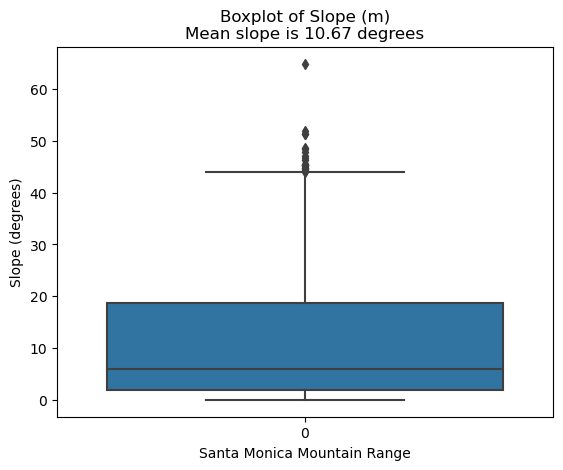

count    19836.000000
mean        10.670559
std         10.365280
min          0.000000
25%          1.891522
50%          5.890609
75%         18.752480
max         64.823074
Name: slope_cont, dtype: float64

In [15]:
chart=sns.boxplot(data=sm_geo['slope_cont'])
chart.set_title('Boxplot of Slope (m)\nMean slope is 10.67 degrees')
chart.set_ylabel('Slope (degrees)')
chart.set_xlabel('Santa Monica Mountain Range')
plt.show()

sm_geo['slope_cont'].describe()

I will categorize the elevation into four quartiles:
* $0-25\%$
* $25-50\%$
* $50-75\%$
* $>75\%$

In [16]:
def slopeCategorizer(df_col):
    '''
    Hard-codes slope bins into:
    
    low, medium, high, very high
    0-1.89, 1.89-5.89, 5.89-18.75, 18.75-64.823074
    '''
    
    if df_col <= 1.89:
        return 'slope_low'
    elif df_col <= 5.89:
        return 'slope_med'
    elif df_col <= 18.75:
        return 'slope_high'
    else:
        return 'slope_vhigh'
        
slopeCategorizer(45)

'slope_vhigh'

In [17]:
# `.apply` the function elevCategorizer
# to each row in the column thusly:
sm_geo['slope_cat']=sm_geo['slope_cont'].apply(slopeCategorizer)
sm_geo

,asp_cont,asp_cat,elev_cont,elev_cat,slope_cont,slope_cat,fire
0,90.000000,E,229.0,elev_high,1.891522,slope_med,0
1,180.000000,S,230.0,elev_high,0.535182,slope_low,0
2,147.528809,SSE,227.0,elev_high,2.269464,slope_med,0
3,149.036240,SSE,226.0,elev_high,1.559970,slope_low,0
4,206.565048,SSW,228.0,elev_high,2.037113,slope_med,0
...,...,...,...,...,...,...,...
19831,249.702423,WSW,92.0,elev_low,19.977131,slope_vhigh,1
19832,222.709396,SW,120.0,elev_low,18.289597,slope_high,1
19833,228.990921,SW,134.0,elev_low,15.892071,slope_high,1
19834,233.686356,SW,149.0,elev_low,25.691380,slope_vhigh,1


In [18]:
sm_geo['slope_cat'].value_counts()

slope_med      5012
slope_vhigh    4962
slope_high     4957
slope_low      4905
Name: slope_cat, dtype: int64

Like the elevation in the area, the slopes are evenly distributed. I was not expecting that.

## Prepare data for analysis

#### `get_dummies` on the `asp_cat` column

In [19]:
sm_geo_aspCat=pd.get_dummies(data=sm_geo['asp_cat'])
sm_geo_aspCat

,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19831,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
19832,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
19833,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
19834,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [20]:
# add binarized columns back to dataframe
sm_geo=pd.concat([sm_geo,sm_geo_aspCat],axis=1)
sm_geo

,asp_cont,asp_cat,elev_cont,elev_cat,slope_cont,slope_cat,fire,E,ENE,ESE,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
0,90.000000,E,229.0,elev_high,1.891522,slope_med,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,180.000000,S,230.0,elev_high,0.535182,slope_low,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,147.528809,SSE,227.0,elev_high,2.269464,slope_med,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,149.036240,SSE,226.0,elev_high,1.559970,slope_low,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,206.565048,SSW,228.0,elev_high,2.037113,slope_med,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19831,249.702423,WSW,92.0,elev_low,19.977131,slope_vhigh,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
19832,222.709396,SW,120.0,elev_low,18.289597,slope_high,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
19833,228.990921,SW,134.0,elev_low,15.892071,slope_high,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
19834,233.686356,SW,149.0,elev_low,25.691380,slope_vhigh,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


#### `get_dummies` on the `elev_cat` column

In [21]:
# dummies
sm_geo_elevCat=pd.get_dummies(data=sm_geo['elev_cat'])

# add binarized columns back to dataframe
sm_geo=pd.concat([sm_geo,sm_geo_elevCat],axis=1)

# # reset axis
# sm_geo=sm_geo.reset_index()

# sm_geo=sm_geo.drop(labels=['index','elev_cat','asp_cat'],axis=1)

sm_geo

,asp_cont,asp_cat,elev_cont,elev_cat,slope_cont,slope_cat,fire,E,ENE,ESE,...,SSE,SSW,SW,W,WNW,WSW,elev_high,elev_low,elev_med,elev_vhigh
0,90.000000,E,229.0,elev_high,1.891522,slope_med,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,180.000000,S,230.0,elev_high,0.535182,slope_low,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,147.528809,SSE,227.0,elev_high,2.269464,slope_med,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,149.036240,SSE,226.0,elev_high,1.559970,slope_low,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
4,206.565048,SSW,228.0,elev_high,2.037113,slope_med,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19831,249.702423,WSW,92.0,elev_low,19.977131,slope_vhigh,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
19832,222.709396,SW,120.0,elev_low,18.289597,slope_high,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
19833,228.990921,SW,134.0,elev_low,15.892071,slope_high,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
19834,233.686356,SW,149.0,elev_low,25.691380,slope_vhigh,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0


#### `get_dummies` on the `slope_cat` column

In [22]:
# dummies
sm_geo_slopeCat=pd.get_dummies(data=sm_geo['slope_cat'])

# add binarized columns back to dataframe
sm_geo=pd.concat([sm_geo,sm_geo_slopeCat],axis=1)

sm_geo

,asp_cont,asp_cat,elev_cont,elev_cat,slope_cont,slope_cat,fire,E,ENE,ESE,...,WNW,WSW,elev_high,elev_low,elev_med,elev_vhigh,slope_high,slope_low,slope_med,slope_vhigh
0,90.000000,E,229.0,elev_high,1.891522,slope_med,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
1,180.000000,S,230.0,elev_high,0.535182,slope_low,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,147.528809,SSE,227.0,elev_high,2.269464,slope_med,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,149.036240,SSE,226.0,elev_high,1.559970,slope_low,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,206.565048,SSW,228.0,elev_high,2.037113,slope_med,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19831,249.702423,WSW,92.0,elev_low,19.977131,slope_vhigh,1,0,0,0,...,0,1,0,1,0,0,0,0,0,1
19832,222.709396,SW,120.0,elev_low,18.289597,slope_high,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
19833,228.990921,SW,134.0,elev_low,15.892071,slope_high,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
19834,233.686356,SW,149.0,elev_low,25.691380,slope_vhigh,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [23]:
# define X and y

droppedcols=['fire','asp_cat','elev_cat','slope_cat']

cols=[col for col in sm_geo.columns if col not in droppedcols]

X=sm_geo[cols]
y=sm_geo[['fire']]

X

,asp_cont,elev_cont,slope_cont,E,ENE,ESE,N,NE,NNE,NNW,...,WNW,WSW,elev_high,elev_low,elev_med,elev_vhigh,slope_high,slope_low,slope_med,slope_vhigh
0,90.000000,229.0,1.891522,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,180.000000,230.0,0.535182,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,147.528809,227.0,2.269464,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,149.036240,226.0,1.559970,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,206.565048,228.0,2.037113,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19831,249.702423,92.0,19.977131,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
19832,222.709396,120.0,18.289597,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
19833,228.990921,134.0,15.892071,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
19834,233.686356,149.0,25.691380,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [24]:
print(X.shape)
print(y.shape)

(19836, 27)
(19836, 1)


In [25]:
# reshape the y data into a 1D array for sklearn modeling

y_array=np.ravel(a=y,order='C')
y_array.shape

(19836,)

In [26]:
y.mean()

fire    0.5
dtype: float64

The dataset has $50{\%}$ of the landscape enduring a wildfire. I call this the *base rate*, as in, what would a 'dumb model' predict if an area is predicted to have a fire or not.

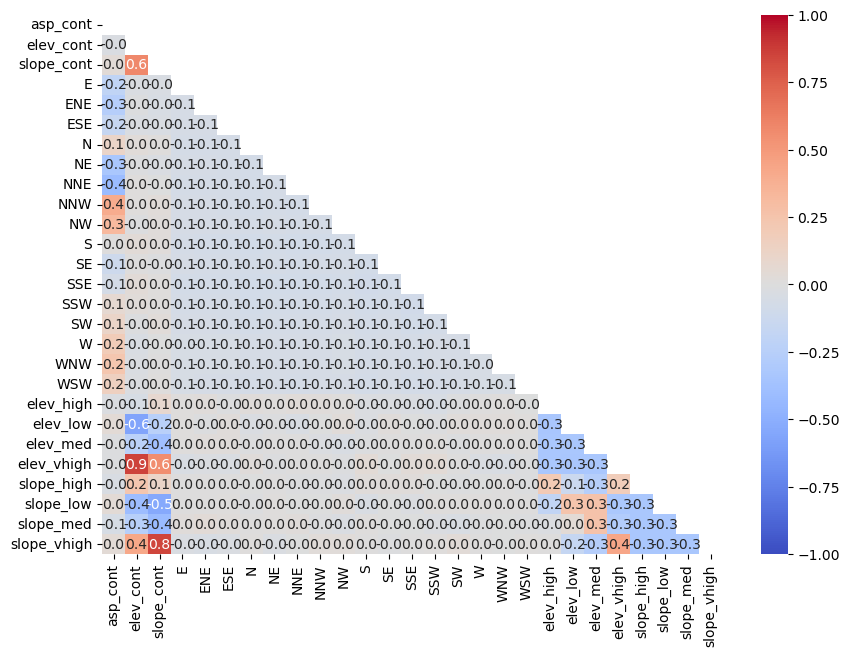

In [27]:
plt.figure(figsize=(10,7))
mask=np.triu(np.ones_like(X.corr(),dtype=bool))
sns.heatmap(data=X.corr(),
            annot=True, 
            fmt='.1f',
            cmap='coolwarm',
            vmin=-1,vmax=1,
            mask=mask)
plt.show()

There is no collinearity between aspect, slope, and elevation. Any collinearity between aspect bins and `asp_cont` is soley because aspects of `NW` and `NNW` are the highest aspect values (i.e., closest to 360 degrees). Same is true for `elev_cont`: `low` and `vhigh` elevations are negatively and positively correlated with the continuous elevation column. Slope is also predictably correlated: the categorical slopes are correlated with `slope_cont`. Categorical elevation and slopes are both correlated with `elev_cont` and `slope_cont`. All of this is to be expected. I should drop the categorical elevations and slopes, but will run some models first.

## Modeling

### Basic logistic regression:

#### `statsmodels`:

In [28]:
# add constant to prepare for statsmodels

X_withconstant=sm.add_constant(X)
X_withconstant.head()

,const,asp_cont,elev_cont,slope_cont,E,ENE,ESE,N,NE,NNE,...,WNW,WSW,elev_high,elev_low,elev_med,elev_vhigh,slope_high,slope_low,slope_med,slope_vhigh
0,1.0,90.000000,229.0,1.891522,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,1.0,180.000000,230.0,0.535182,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,1.0,147.528809,227.0,2.269464,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,1.0,149.036240,226.0,1.559970,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,1.0,206.565048,228.0,2.037113,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [29]:
X_withconstant_binary=X_withconstant.drop(['asp_cont','elev_cont','slope_cont'],axis=1)

In [30]:
X_withconstant_binary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19836 entries, 0 to 19835
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   const        19836 non-null  float64
 1   E            19836 non-null  uint8  
 2   ENE          19836 non-null  uint8  
 3   ESE          19836 non-null  uint8  
 4   N            19836 non-null  uint8  
 5   NE           19836 non-null  uint8  
 6   NNE          19836 non-null  uint8  
 7   NNW          19836 non-null  uint8  
 8   NW           19836 non-null  uint8  
 9   S            19836 non-null  uint8  
 10  SE           19836 non-null  uint8  
 11  SSE          19836 non-null  uint8  
 12  SSW          19836 non-null  uint8  
 13  SW           19836 non-null  uint8  
 14  W            19836 non-null  uint8  
 15  WNW          19836 non-null  uint8  
 16  WSW          19836 non-null  uint8  
 17  elev_high    19836 non-null  uint8  
 18  elev_low     19836 non-null  uint8  
 19  elev

In [31]:
# instantiate model with binary variables
logreg_sm_binary=sm.Logit(y,X_withconstant_binary)

# fit the model
logreg_sm_binary_results=logreg_sm_binary.fit()

# summary
logreg_sm_binary_results.summary()

         Current function value: 0.147414
         Iterations: 35


/Applications/Anaconda/anaconda3/envs/sklearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   fire   No. Observations:                19836
Model:                          Logit   Df Residuals:                    19811
Method:                           MLE   Df Model:                           24
Date:                Fri, 07 Apr 2023   Pseudo R-squ.:                  0.7873
Time:                        23:27:57   Log-Likelihood:                -2924.1
converged:                      False   LL-Null:                       -13749.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.4033        nan        nan        nan         nan         nan
E              -0.0813   6.17e+06  -1.32e-08      1.000   -1.21e+07    1.21e+07
ENE            -0.5071   6.18e+06  -8.21e-08      1.000   -1.21e+07    1.21e+07
ESE             0.1251   6.13e+06   2.04e-08      1.000    -1.2e+07     1.2e+07
N              -0.6563   6.11e+06  -1.07e-07      1.000    -1.2e+07     1.2e+07
NE             -0.4147   6.17e+06  -6.72e-08      1.000   -1.21e+07    1.21e+07
NNE            -0.8274   6.14e+06  -1.35e-07      1.000    -1.2e+07     1.2e+07
NNW            -0.3884   6.17e+06   -6.3e-08      1.000   -1.21e+07    1.21e+07
NW             -0.1040   6.13e+06   -1.7e-08      1.000    -1.2e+07     1.2e+07
S               1.1339   6.14e+06   1.85e-07      1.000    -1.2e+07     1.2e+07
SE              0.7937   6.18e+06   1.28e-07      1.000   -1.21e+07    1.21e+07
SSE             1.1780   6.16e+06   1.91e-07      1.000   -1.21e+07    1.21e+07
SSW             0.9348   6.13e+06   1.53e-07      1.000    -1.2e+07     1.2e+07
SW              0.7599   6.09e+06   1.25e-07      1.000   -1.19e+07    1.19e+07
W               0.5685   6.13e+06   9.28e-08      1.000    -1.2e+07     1.2e+07
WNW             0.3592   6.13e+06   5.86e-08      1.000    -1.2e+07     1.2e+07
WSW             0.5293    6.1e+06   8.67e-08      1.000    -1.2e+07     1.2e+07
elev_high      -4.6844   5.34e+06  -8.78e-07      1.000   -1.05e+07    1.05e+07
elev_low       -4.5733    5.4e+06  -8.46e-07      1.000   -1.06e+07    1.06e+07
elev_med       -5.9449   5.48e+06  -1.08e-06      1.000   -1.07e+07    1.07e+07
elev_vhigh     18.6059    5.5e+06   3.39e-06      1.000   -1.08e+07    1.08e+07
slope_high      2.7269        nan        nan        nan         nan         nan
slope_low      -3.5361        nan        nan        nan         nan         nan
slope_med      -1.2367        nan        nan        nan         nan         nan
slope_vhigh     5.4492        nan        nan        nan         nan         nan
===============================================================================

Possibly complete quasi-separation: A fraction 0.25 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [32]:
# make the results from the statsmodels logistic regresion
# into a dataframe to compare betas.
# make sure to raise e to the beta to convert to odds

results=logreg_sm_binary_results.params
col_names=list(X_withconstant_binary.columns)
col_vals=[]

for i in range(len(results)):
    col_vals.append(results[i])
    
results_=list(zip(col_names,col_vals))
results_df=pd.DataFrame(results_,columns=['beta_name','beta_logOdds'])

results_df['beta_odds']=results_df['beta_logOdds'].apply(np.exp)
results_df=results_df.sort_values('beta_odds',ascending=False)
results_df=results_df.reset_index()
results_df=results_df.drop(labels=['index'],axis=1)

results_df.sort_values('beta_odds',ascending=False)

,beta_name,beta_logOdds,beta_odds
0,elev_vhigh,18.605948,1.203541e+08
1,slope_vhigh,5.449223,2.325774e+02
2,const,3.403293,3.006293e+01
3,slope_high,2.726863,1.528487e+01
4,SSE,1.178004,3.247886e+00
5,S,1.133871,3.107664e+00
6,SSW,0.934801,2.546707e+00
7,SE,0.793725,2.211620e+00
8,SW,0.759857,2.137970e+00
9,W,0.568527,1.765664e+00


Using the binary columns, being at very high elevations, facing south or west, and having high slopes, give the highest probability of a fire occurring. However, the p-value is very high, so this result is not significant.

What if I run the model with only the continuous variables?

**But first, we need to scale the data:**

In [33]:
# setup X for continuous columns

droppedcols=['E','ENE','ESE','N','NE','NNE','NNW','NW','S','SE','SSE','SSW','SW','W','WNW','WSW',
             'elev_high','elev_low','elev_med','elev_vhigh',
            'slope_vhigh','slope_high','slope_med','slope_low']

cols=[col for col in X_withconstant.columns if col not in droppedcols]

X_withconstant_continuous=X_withconstant[cols]

In [34]:
# drop constant, I'll add this again after scaling
X_withconstant_continuous=X_withconstant_continuous.drop('const',axis=1)

In [35]:
X_withconstant_continuous.head()

,asp_cont,elev_cont,slope_cont
0,90.000000,229.0,1.891522
1,180.000000,230.0,0.535182
2,147.528809,227.0,2.269464
3,149.036240,226.0,1.559970
4,206.565048,228.0,2.037113


In [36]:
# instantiate scaler
scaler=StandardScaler()

# fit scaler on X
X_withconstant_continuous_scaled=scaler.fit_transform(X_withconstant_continuous)

In [37]:
X_withconstant_continuous_scaled

array([[-0.86282054, -0.25858088, -0.84698711],
       [ 0.01072149, -0.253666  , -0.97784456],
       [-0.30444463, -0.26841063, -0.81052389],
       ...,
       [ 0.48622847, -0.72549423,  0.50376285],
       [ 0.53180246, -0.65177107,  1.44918407],
       [ 0.47237647, -0.43060158,  1.71459911]])

In [38]:
# add constant
X_withconstant_continuous_scaled=sm.add_constant(X_withconstant_continuous_scaled)

In [39]:
X_withconstant_continuous_scaled

array([[ 1.        , -0.86282054, -0.25858088, -0.84698711],
       [ 1.        ,  0.01072149, -0.253666  , -0.97784456],
       [ 1.        , -0.30444463, -0.26841063, -0.81052389],
       ...,
       [ 1.        ,  0.48622847, -0.72549423,  0.50376285],
       [ 1.        ,  0.53180246, -0.65177107,  1.44918407],
       [ 1.        ,  0.47237647, -0.43060158,  1.71459911]])

In [40]:
# instantiate model
logreg_sm_cont=sm.Logit(y,X_withconstant_continuous_scaled)

# fit the model
logreg_sm_cont_results=logreg_sm_cont.fit()

# summary
logreg_sm_cont_results.summary()

Optimization terminated successfully.
         Current function value: 0.165467
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   fire   No. Observations:                19836
Model:                          Logit   Df Residuals:                    19832
Method:                           MLE   Df Model:                            3
Date:                Fri, 07 Apr 2023   Pseudo R-squ.:                  0.7613
Time:                        23:28:04   Log-Likelihood:                -3282.2
converged:                       True   LL-Null:                       -13749.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6987      0.052     32.369      0.000       1.596       1.802
x1             0.1306      0.033      3.953      0.000       0.066       0.195
x2             1.8135      0.070     25.968      0.000       1.677       1.950
x3             4.5541      0.082     55.809      0.000       4.394       4.714
==============================================================================

Possibly complete quasi-separation: A fraction 0.13 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [41]:
# make the results from the statsmodels logistic regresion
# into a dataframe to compare betas.
# make sure to raise e to the beta to convert to odds

results=logreg_sm_cont_results.params
col_names=list(X_withconstant_continuous.columns)
col_vals=[]

for i in range(len(results)):
    col_vals.append(results[i])
    
results_=list(zip(col_names,col_vals))
results_df=pd.DataFrame(results_,columns=['beta_name','beta_logOdds'])

results_df['beta_odds']=results_df['beta_logOdds'].apply(np.exp)
results_df=results_df.sort_values('beta_odds',ascending=False)
results_df=results_df.reset_index()
results_df=results_df.drop(labels=['index'],axis=1)

results_df.sort_values(by='beta_odds',ascending=False)

,beta_name,beta_logOdds,beta_odds
0,slope_cont,1.813518,6.131984
1,asp_cont,1.698651,5.466566
2,elev_cont,0.130628,1.139544


The results of the logistic regression show that as the slope increases, the odds of a fire increase $6.13$ times. As the aspect gets closer to NW and NNW, the odds of a fire go up almost $5.5$ times. Elevation has less of an effect on fire risk, increasing the risk just $1.14$ times.

#### `sklearn`:

##### Train, Test, Split

Partition dataset to have $0.\overline3$ of the total as testing.

In [42]:
X.shape

(19836, 27)

In [43]:
X.columns

Index(['asp_cont', 'elev_cont', 'slope_cont', 'E', 'ENE', 'ESE', 'N', 'NE',
       'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE', 'SSW', 'SW', 'W', 'WNW', 'WSW',
       'elev_high', 'elev_low', 'elev_med', 'elev_vhigh', 'slope_high',
       'slope_low', 'slope_med', 'slope_vhigh'],
      dtype='object')

In [44]:
y_array.shape

(19836,)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y_array, test_size=(1/3),stratify=y)

In [46]:
print(f'''
X_train shape: {X_train.shape}\n
y_train shape: {y_train.shape}\n
X_test shape: {X_test.shape}\n
y_test shape: {y_test.shape}
''')


X_train shape: (13224, 27)

y_train shape: (13224,)

X_test shape: (6612, 27)

y_test shape: (6612,)



##### Basic `sklearn` `LogisticRegression`

In [48]:
# instantiate model
logreg=LogisticRegression(max_iter=10000)

# fit the model
logreg.fit(X_train,y_train)

print('Training Score: ',logreg.score(X_train,y_train))
print('Testing Score:  ',logreg.score(X_test,y_test))

Training Score:  0.9530399274047187
Testing Score:   0.9516031457955233


Wow, this is a very good result. Adding slope greatly increased the accuracy of the model. Before adding the slope, in a previous iteration of the model, had accuracy in the low 80s. 

For reference, here are my notes from the last iteration: good match with the training set, though the accuracy is lower than I'd like. It's great to see that the accuracy is a lot higher than the base rate of $50\%$ . I'll need to scale the data too.

This scaler will be used later in the notebook, as this is a purely scaled version of all the X data:

In [49]:
# add scaler
logreg_scaler=StandardScaler()

# fit scaler on train
logreg_scaler.fit(X_train)

# transform train data
X_scaled_train=logreg_scaler.transform(X_train)
X_scaled_test=logreg_scaler.transform(X_test)

# apply scaled data to logreg model
logreg_scaled = LogisticRegression(C=1,
                                   solver='lbfgs',
                                   max_iter=10000)\
.fit(X_scaled_train, y_train)

print('Training Score: ',logreg_scaled.score(X_scaled_train,y_train))
print('Testing Score:  ',logreg_scaled.score(X_scaled_test,y_test))

Training Score:  0.9531911675741077
Testing Score:   0.9511494252873564


After applying a scaler, the training and test score remained virtually the same. The scaling would only work on the continuous elevation and aspect columns, since the others are binary.

Let's play around with the hyperparameters to see if the accuracy is higher at a particular value.

First, let's create a validation set from the training set. We'll aim for 80% of our data be relegated towards training and validation, and 20% being relegated towards testing.

In [50]:
print(f'There are {sm_geo.shape[0]} rows in the dataset')

There are 19836 rows in the dataset


In [51]:
testing_size=0.2
val_size=0.3

In [52]:
X_remainder, X_test, y_remainder, y_test = \
    train_test_split(X.values, y_array, 
                     test_size = testing_size,stratify=y)

X_train, X_validation, y_train, y_validation = \
    train_test_split(X_remainder, y_remainder, 
                     test_size = val_size,stratify=y_remainder)

print(f'Shape of test set:       {X_test.shape}')
print(f'Shape of validation set: {X_validation.shape}')
print(f'Shape of train set:      {X_train.shape}')

Shape of test set:       (3968, 27)
Shape of validation set: (4761, 27)
Shape of train set:      (11107, 27)


Test different C values:

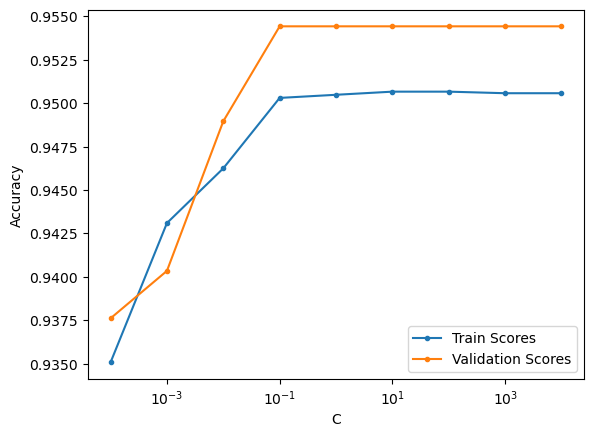

In [53]:
C_range=np.logspace(-4,4,9)

validation_scores=[]
train_scores=[]

for c in C_range:
    tuning_logreg=LogisticRegression(C=c,max_iter=10000)
    tuning_logreg.fit(X_train,y_train)
    
    # train on traning set
    train_scores.\
    append(tuning_logreg.score(X_train,y_train))
    # score on validation set
    validation_scores.\
    append(tuning_logreg.score(X_validation,y_validation))

plt.figure()
plt.plot(C_range, train_scores,label="Train Scores",marker='.')
plt.plot(C_range, validation_scores,label="Validation Scores",marker='.')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

It looks like When $C=10^{-1}$, we get the best accuracy for the lowest spread between validation and training.

An accuracy of over 95% is excellent.

For reference, here are the notes from a previous model, one that did not have slope values. We get better accuracy than the basic model, but that's not good enough. Now let's try to increase the accuracy of our model with a grid search. We want to find the best possible accuracy. Let's try to break $90\%$!

In [54]:
X_train.shape

(11107, 27)

In [55]:
y_train.shape

(11107,)

### Grid Search

In [56]:
estimators = [('normalise', None),
              ('model', None)]#,
              # ('pca',None)]

pipe = Pipeline(estimators)

param_grid = [
            {'model': [LogisticRegression(max_iter=10000)],
             'model': [LogisticRegression(max_iter=10000,penalty='l1',solver='liblinear'),
                       LogisticRegression(max_iter=10000,penalty='l2')],
             'normalise': [StandardScaler(), None],
             'model__C': np.logspace(-2,1,20)}#,
             # 'pca': ['passthrough',PCA()]}
]

grid = GridSearchCV(pipe, 
                    param_grid, 
                    cv=5,
                    verbose=3,
                    n_jobs=7,
                    scoring="f1_weighted")

fittedgrid = grid.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


In [57]:
fittedgrid.best_estimator_

Pipeline(steps=[('normalise', None),
                ('model',
                 LogisticRegression(C=0.5455594781168517, max_iter=10000))])

In [58]:
fittedgrid.best_params_

{'model': LogisticRegression(C=0.5455594781168517, max_iter=10000),
 'model__C': 0.5455594781168517,
 'normalise': None}

In [59]:
fittedgrid.score(X_test,y_test)

0.9551403996553013

My best results ($95\%$) were with a C value of $0.546$.

### Random Forest

In [60]:
from sklearn.ensemble import RandomForestClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn.svm import SVC

In [61]:
random_forest_model = RandomForestClassifier(n_estimators=50 )
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50)

In [62]:
# score on random forest

# Instantiate lists to save scores in
decision_tree_train_scores = []
decision_tree_test_scores = []
# For each tree, score on train and test
for sub_tree in random_forest_model.estimators_:
    decision_tree_train_scores.append(sub_tree.score(X_train, y_train))
    decision_tree_test_scores.append(sub_tree.score(X_test, y_test))

# Rather than many separate print() statements, we can combine them into one using triple quotes.
print(f"""
Performance on fitted data:
Average Decision Tree: {np.mean(decision_tree_train_scores)}
Random Forest: {random_forest_model.score(X_train, y_train)}
----------------
Performance on test data:
Average Decision Tree: {np.mean(decision_tree_test_scores)}
Random Forest: {random_forest_model.score(X_test, y_test)}
""")


Performance on fitted data:
Average Decision Tree: 0.979967588007563
Random Forest: 0.9996398667506977
----------------
Performance on test data:
Average Decision Tree: 0.948649193548387
Random Forest: 0.9647177419354839



The random forest got the accuracy past $96\%$, nice!

In [63]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# evaluate base model
y_pred = random_forest_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1984
           1       0.96      0.97      0.96      1984

    accuracy                           0.96      3968
   macro avg       0.96      0.96      0.96      3968
weighted avg       0.96      0.96      0.96      3968



The random forest showed the highest accuracy yet!

### Naive Bayes

In [64]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

In [65]:
# models
nbmodel_bern = BernoulliNB()
nbmodel_bern.fit(X_train,y_train)
print("Bernoulli (train): --",nbmodel_bern.score(X_train,y_train))
print("Bernoulli (test): ---",nbmodel_bern.score(X_test,y_test))
nbmodel_gauss = GaussianNB()
nbmodel_gauss.fit(X_train,y_train)
print("Gauss (train): ------",nbmodel_gauss.score(X_train,y_train))
print("Gauss (test): -------",nbmodel_gauss.score(X_test,y_test))
nbmodel_multi = MultinomialNB()
nbmodel_multi.fit(X_train,y_train)
print("Multinomial (train):-",nbmodel_multi.score(X_train,y_train))
print("Multinomial (test): -",nbmodel_multi.score(X_test,y_test))

Bernoulli (train): -- 0.9400378139911767
Bernoulli (test): --- 0.9478326612903226
Gauss (train): ------ 0.9439992797335014
Gauss (test): ------- 0.9460685483870968
Multinomial (train):- 0.7305302962095975
Multinomial (test): - 0.7376512096774194


These do not perform as well as the random forest, but are still very strong. The `Bernoulli` and `Gauss` performed much better than the `Multinomial`.

Let's try some boosting-type models.

### Boosting

#### AdaBoost

In [66]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

from sklearn.ensemble import AdaBoostClassifier

# fitting AdaBoost model with 2 estimators
abc_2 = AdaBoostClassifier(n_estimators=2)
abc_2.fit(X_train_scale, y_train)

# define base estimator with max_depth=2
from sklearn.tree import DecisionTreeClassifier
base_tree = DecisionTreeClassifier(max_depth=2)

# fit the base decision tree as a benchmark
base_tree.fit(X_train_scale, y_train)

# evaluate base model
y_pred = base_tree.predict(X_test_scale)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      1984
           1       0.92      0.98      0.95      1984

    accuracy                           0.95      3968
   macro avg       0.95      0.95      0.95      3968
weighted avg       0.95      0.95      0.95      3968



Basic abc accuracy: 0.9652217741935484


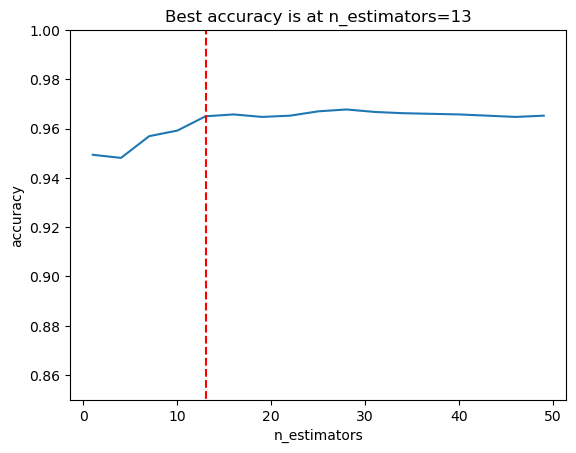

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1984
           1       0.96      0.97      0.97      1984

    accuracy                           0.97      3968
   macro avg       0.97      0.97      0.97      3968
weighted avg       0.97      0.97      0.97      3968



In [70]:
estimators = list(range(1, 50, 3))

abc_scores = []
for n_est in estimators:
    abc = AdaBoostClassifier(
        estimator=base_tree, 
        n_estimators = n_est)
    
    abc.fit(X_train_scale, y_train)
    y_pred = abc.predict(X_test_scale)
    abc_scores.append(accuracy_score(y_test, y_pred))

# print score for basic abc:
print(f'Basic abc accuracy: {abc.score(X_test_scale,y_test)}')

# plot test scores and n_estimators
plt.plot(estimators, abc_scores)
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.ylim([0.85, 1])
plt.title('Best accuracy is at n_estimators=13')
plt.vlines(x=13,ymin=.8,ymax=1.1,linestyles='dashed',color='red')
plt.show()

print(classification_report(y_test, y_pred))

A result of $96\%$, wow! This is with about $13$ estimators.

What about gradient boosting?

#### Gradient Boosting

In [71]:
from sklearn.ensemble import GradientBoostingClassifier

gbc_2 = GradientBoostingClassifier()
gbc_2.fit(X_train_scale, y_train)

gbc_2.score(X_test_scale,y_test)
y_pred = gbc_2.predict(X_test_scale)
print(f'Basic gbc score: {gbc_2.score(X_test_scale,y_test)}')
print(classification_report(y_test, y_pred))

Basic gbc score: 0.9690020161290323
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1984
           1       0.96      0.98      0.97      1984

    accuracy                           0.97      3968
   macro avg       0.97      0.97      0.97      3968
weighted avg       0.97      0.97      0.97      3968



In [72]:
gbc = GradientBoostingClassifier()

parameters = {
    'loss': ['log_loss', 'exponential'],
    'learning_rate': [0.001, 0.1, 1, 10],
    'n_estimators': [100, 150, 180, 200]
}
grid_search_gbc = GridSearchCV(gbc, parameters, cv = 5, n_jobs = 7, verbose = 3)
grid_search_gbc.fit(X_train_scale, y_train)

# best score
print(f"best score: {grid_search_gbc.best_score_}")

# best parameters 
print(f"best parameters: {grid_search_gbc.best_params_}")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
best score: 0.9664178079221701
best parameters: {'learning_rate': 0.1, 'loss': 'log_loss', 'n_estimators': 200}


Almost $97\%$! It's notable that the basic `gbc` performs better than the grid search.

#### XGBoost

In [73]:
from xgboost import XGBClassifier

xgbc = XGBClassifier()
xgbc.fit(X_train_scale, y_train)

y_pred = xgbc.predict(X_test_scale)
print(f'Score on test: {xgbc.score(X_test_scale,y_test)}')
print(classification_report(y_test, y_pred))

Score on test: 0.9639616935483871
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1984
           1       0.96      0.97      0.96      1984

    accuracy                           0.96      3968
   macro avg       0.96      0.96      0.96      3968
weighted avg       0.96      0.96      0.96      3968



## Exploring Hyperparameter Space with `GradientBoostingClassifier`.
### Aiming for $>96\%$: This gave us the best accuracy.

Let's explore these parameters to try to increase the accuracy:

best score: `0.9664178079221701`  
best parameters:  
`{'learning_rate': 0.1, 'loss': 'log_loss', 'n_estimators': 200}`

In [75]:
gbc = GradientBoostingClassifier()

parameters = {
    'loss': ['exponential'],
    'learning_rate': (np.logspace(-1.3,-.8239,10)),
    'n_estimators': (np.linspace(195,205,10)).astype(int)
}
grid_search_gbc = GridSearchCV(gbc, parameters, cv = 5, n_jobs = 7, verbose = 3)
grid_search_gbc.fit(X_train_scale, y_train)

# best score
print(f"best score: {grid_search_gbc.best_score_}")

# best parameters 
print(f"best parameters: {grid_search_gbc.best_params_}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
best score: 0.9654275062805695
best parameters: {'learning_rate': 0.11757094257962457, 'loss': 'exponential', 'n_estimators': 195}


I am reaching diminishing returns and will stop there. The grid search was unsuccessful because the best score was worse than the GradientBooster from a few cells above, reproduced below:

best score: `0.9664178079221701`  
best parameters: `{'learning_rate': 0.1, 'loss': 'log_loss', 'n_estimators': 200}`

### Transform all of X on the scaler, then run through an optimized `GradientBoostingClassifier`

Remind ourselves of `X` and `y`:

In [76]:
X.head(1)

,asp_cont,elev_cont,slope_cont,E,ENE,ESE,N,NE,NNE,NNW,...,WNW,WSW,elev_high,elev_low,elev_med,elev_vhigh,slope_high,slope_low,slope_med,slope_vhigh
0,90.0,229.0,1.891522,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [77]:
y.head(1)

,fire
0,0


Reminder on the correlation between the factors:

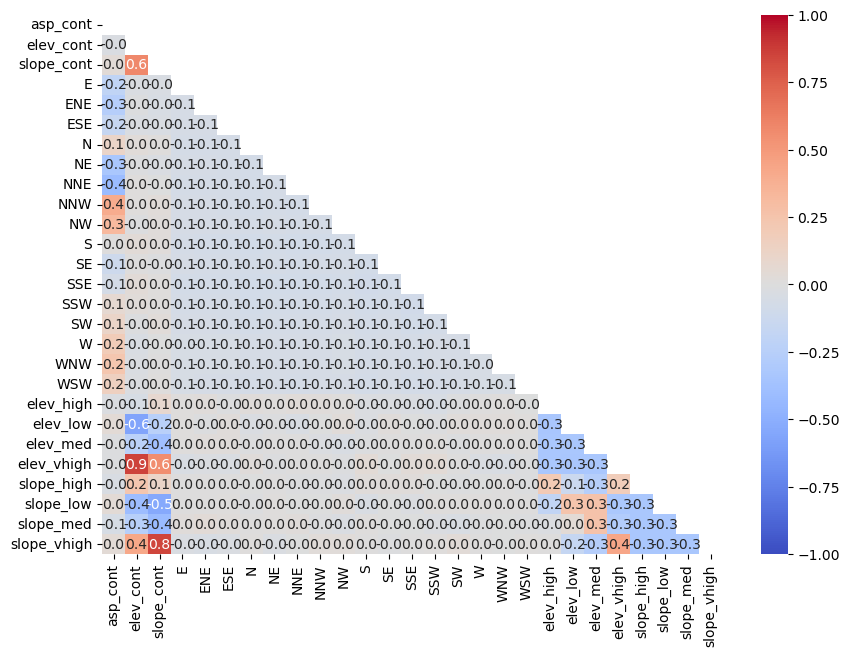

In [81]:
plt.figure(figsize=(10,7))
mask=np.triu(np.ones_like(X.corr(),dtype=bool))
sns.heatmap(data=X.corr(),
            annot=True, 
            fmt='.1f',
            cmap='coolwarm',
            vmin=-1,vmax=1,
            mask=mask)
plt.show()

I will drop the categorical aspect and elevation columns as discussed previously, because of their collinearity.

In [79]:
X.head()

,asp_cont,elev_cont,slope_cont,E,ENE,ESE,N,NE,NNE,NNW,...,WNW,WSW,elev_high,elev_low,elev_med,elev_vhigh,slope_high,slope_low,slope_med,slope_vhigh
0,90.000000,229.0,1.891522,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,180.000000,230.0,0.535182,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,147.528809,227.0,2.269464,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,149.036240,226.0,1.559970,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,206.565048,228.0,2.037113,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [80]:
X.shape

(19836, 27)

In [85]:
# prepare an X for the optimized hyperparameter GBC
# drop columns as discussed above
# X_optimized=X.drop(labels=['asp_cont','elev_vhigh','elev_high','elev_med','elev_low','slope_vhigh','slope_high','slope_med','slope_low'],axis=1)

X_optimized=X.copy()
# X_optimized

Transform the optimized X to the `logreg_scaler` that was created earlier:

In [86]:
X_optimized_scaled=logreg_scaler.transform(X_optimized)

/Applications/Anaconda/anaconda3/envs/sklearn/lib/python3.9/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [87]:
X_optimized_scaled

array([[-0.86709382, -0.26190766, -0.84754651, ..., -0.57292606,
         1.71887913, -0.57991163],
       [ 0.01156797, -0.25702726, -0.97790956, ...,  1.74542592,
        -0.58177447, -0.57991163],
       [-0.30544531, -0.27166845, -0.81122106, ..., -0.57292606,
         1.71887913, -0.57991163],
       ...,
       [ 0.48986187, -0.72554542,  0.49810004, ..., -0.57292606,
        -0.58177447, -0.57991163],
       [ 0.53570297, -0.65233946,  1.43994927, ..., -0.57292606,
        -0.58177447,  1.72440068],
       [ 0.47592869, -0.43272157,  1.70436152, ..., -0.57292606,
        -0.58177447,  1.72440068]])

In [88]:
X_optimized_scaled.shape

(19836, 27)

Run the `GradientBoostingClassifier` on the optimized hyperparameters. There will be errors but we will ignore them.

In [89]:
gbc=GradientBoostingClassifier(learning_rate=0.1,
                               loss='log_loss',
                               n_estimators=200)
gbc.fit(X=X_optimized_scaled,y=y)

gbc.score(X=X_optimized_scaled,y=y)

/Applications/Anaconda/anaconda3/envs/sklearn/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9724238757814075

$>97\%$ accuracy is quite good!  
I will run `predict_proba` on `X_optimized_scaled`, then take one column of this output probability to serve as a new feature that will be added to a new stacked table.

In [90]:
probabilities_X=grid_search_gbc.predict_proba(X_optimized_scaled)
probabilities_X

array([[9.81562254e-01, 1.84377462e-02],
       [9.77176767e-01, 2.28232328e-02],
       [9.17647625e-01, 8.23523750e-02],
       ...,
       [1.00648545e-05, 9.99989935e-01],
       [2.76375163e-07, 9.99999724e-01],
       [4.03388937e-05, 9.99959661e-01]])

In [91]:
probabilities_X.shape

(19836, 2)

Drop one of the columns from the array, because the probabilities should add up to 1 and thus be perfectly correlated:

In [96]:
# 'geo_prob' because these predictions came from the geographic data
geo_prob=probabilities_X[:,1:]
print(geo_prob.shape)
geo_prob

(19836, 1)


array([[0.01843775],
       [0.02282323],
       [0.08235237],
       ...,
       [0.99998994],
       [0.99999972],
       [0.99995966]])

In [113]:
type(geo_prob)

numpy.ndarray

Save the array as a DataFrame and then a `.CSV` so that I can use it in another notebook for the stacked megamodel:

In [121]:
geo_prob_df=pd.DataFrame(geo_prob,columns=['geo_prob'])
geo_prob_df['rownum']=geo_prob_df.index
geo_prob_df=geo_prob_df[['rownum','geo_prob']]
geo_prob_df

,rownum,geo_prob
0,0,0.018438
1,1,0.022823
2,2,0.082352
3,3,0.022845
4,4,0.103090
...,...,...
19831,19831,0.999999
19832,19832,0.999992
19833,19833,0.999990
19834,19834,1.000000


In [97]:
%pwd

'/Users/sra/Files/projects/brainstation/brainstation_2023_ds_capstone/brainstation_2023_ds_capstone/01_capstone_notebooks'

In [122]:
path='/Users/sra/Files/projects/brainstation/brainstation_2023_ds_capstone/brainstation_2023_ds_capstone/01_capstone_notebooks/geo_prob.csv'
geo_prob_df.to_csv(path_or_buf=path)

## Stacking using `StackingClassifier`